# Mean Variance Portfolio and GMV with and without constraints

The goal of that project is to compare The mean variance portfolio (tangency portfolio) and the Global minimum variance portfolio with and without short-sale constraints.

We assume a risk free return of 0% for simplicity sake but it is possible to modify it in the notebook.

We also make sure to compare them to a very simple portfolio : the equally weighted portfolio.

## <u>Summary : 

- [1) MVP & GMV](#1)
    - [1.1) Getting Data](#1.1)
    - [1.2) Closed form computation](#1.2)
    - [1.3) With optimizer](#1.3)
    - [1.4) MV frontier](#1.4)
    - [1.5) Rolling window analysis](#1.5)
- [2) MVP-C & GMV-C](#2)
    - [2.1) First window weights](#2.1)
    - [2.2) Rolling window analysis](#2.3)
- [3) Conclusion](#3)

In [1]:
import pandas as pd   
import numpy as np    
import yfinance as yf 
from scipy.stats import norm
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# Disable the warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# We assume that risk-free rate is 0
rf=0

<a id='1'></a>
## <u> 1.MVP & GMV

<a id='1.1'></a>
### 1.1 Getting Data

In [3]:
# Read the S&P 500 tickers from Wikipedia
url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
sp500_df = pd.read_html(url)[0]  # Read the first table

# Get the tickers
sp500_tickers = sp500_df['Symbol'].tolist()

#Correct tickers for possible incompatibilities with yfinance
sp500_tickers = [ticker.replace('.', '-') for ticker in sp500_tickers]
sp500_tickers[:10]

['MMM', 'AOS', 'ABT', 'ABBV', 'ACN', 'ADBE', 'AMD', 'AES', 'AFL', 'A']

In [4]:
# Download only adjusted close prices for those tickers.
prices = yf.download(
    tickers=sp500_tickers,
    start="2000-01-01",
    end="2022-12-31",
    interval="1mo"
)['Adj Close']

[*********************100%***********************]  503 of 503 completed

6 Failed downloads:
['GEHC']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1mo 2000-01-01 -> 2022-12-31)')
['VLTO', 'SW', 'GEV', 'KVUE', 'SOLV']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1mo 2000-01-01 -> 2022-12-31) (Yahoo error = "Data doesn\'t exist for startDate = 946702800, endDate = 1672462800")')


In [5]:
#Computing returns and dropping NANs
df_new=prices[["MMM","AOS","ABT","ADM","ADBE","ADP","AES","AFL","A","AKAM"]]
df_new=df_new.pct_change().dropna()
df_new.head()

Ticker,MMM,AOS,ABT,ADM,ADBE,ADP,AES,AFL,A,AKAM
Date,,,,,,,,,,
2000-02-01 00:00:00+00:00,-0.058077,-0.121548,0.018418,-0.143617,0.852440,-0.081686,0.046022,-0.158274,0.569405,0.048670
2000-03-01 00:00:00+00:00,0.010757,0.043478,0.066288,0.029132,0.091299,0.107604,-0.060403,0.248551,0.001204,-0.384450
2000-04-01 00:00:00+00:00,-0.021878,0.142361,0.092362,-0.036363,0.086734,0.117546,0.142064,0.071331,-0.147836,-0.385154
2000-05-01 00:00:00+00:00,-0.010101,0.027725,0.063847,0.201258,-0.069251,0.022068,-0.029882,0.058898,-0.169252,-0.324905
2000-06-01 00:00:00+00:00,-0.025796,-0.003720,0.095238,-0.174006,0.154914,-0.026136,0.045846,-0.109695,0.001698,0.778792


<a id='1.2'></a>
### 1.2  Computation with closed form:

In [6]:
est_window=60
estimation_sample=df_new.iloc[:est_window,:]
estimation_sample.shape

(60, 10)

In [7]:
# We compute our expectd returns using the in-sample average returns
mu_ER=estimation_sample.mean()
mu_ER

Ticker
MMM     0.013484
AOS     0.013601
ABT     0.011963
ADM     0.018833
ADBE    0.025861
ADP     0.002514
AES     0.014656
AFL     0.013767
A      -0.001359
AKAM    0.006118
dtype: float64

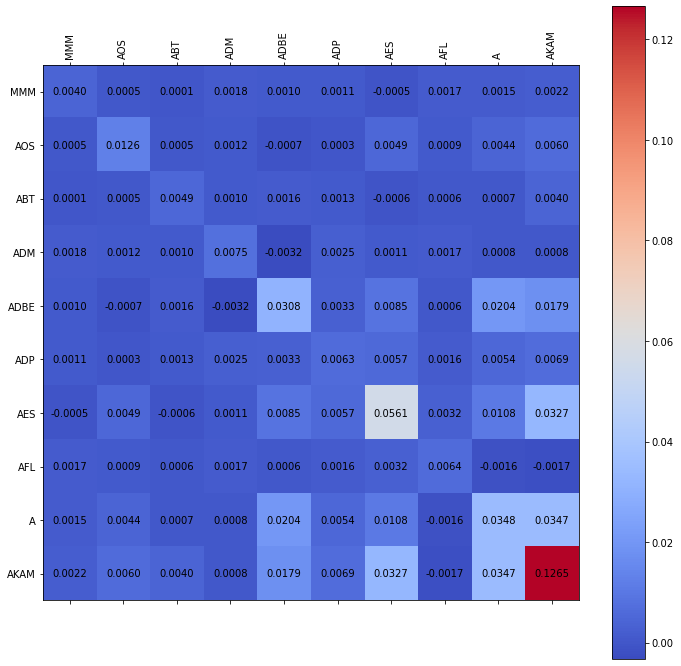

In [8]:
# We compute our sample variance-covariance matrix
cov_mat=estimation_sample.cov()

# Compute inverse covariance matrix
cov_mat_inv = np.linalg.inv(cov_mat)

# Set a unit vector
ones = np.ones((len(cov_mat), 1))

#Plotting : 
labels = cov_mat.index  
fig, ax = plt.subplots(figsize=(12,12))
cax = ax.matshow(cov_mat, cmap='coolwarm')
plt.colorbar(cax)
ax.set_xticks(np.arange(len(labels)))
ax.set_yticks(np.arange(len(labels)))
ax.set_xticklabels(labels, rotation=90)  # Rotate for better visibility
ax.set_yticklabels(labels)

# Add numbers inside the matrix
for i in range(len(labels)):
    for j in range(len(labels)):
        ax.text(j, i, f'{cov_mat.iloc[i, j]:.4f}', ha='center', va='center', color='black')

plt.show()

#### Computation of optimal MVP 

In [9]:
w_mvp= cov_mat_inv@(mu_ER-rf)/(cov_mat_inv@(mu_ER-rf)@ones)
for stock, val in zip(estimation_sample.columns, w_mvp):
    print(f"Weight allocated for stock {stock} is {round(val*100,2)}% ")
    

Weight allocated for stock MMM is 30.63% 
Weight allocated for stock AOS is 15.7% 
Weight allocated for stock ABT is 21.8% 
Weight allocated for stock ADM is 41.16% 
Weight allocated for stock ADBE is 27.69% 
Weight allocated for stock ADP is -23.52% 
Weight allocated for stock AES is 3.51% 
Weight allocated for stock AFL is 1.8% 
Weight allocated for stock A is -18.85% 
Weight allocated for stock AKAM is 0.08% 


#### Computation of  GMV 

In [10]:
w_gmv = (cov_mat_inv @ ones)/(ones.T@cov_mat_inv @ ones)

for stock, val in zip(estimation_sample.columns, w_gmv):
    print(f"Weight allocated for stock {stock} is {round(val[0]*100,2)}% ")

Weight allocated for stock MMM is 33.73% 
Weight allocated for stock AOS is 10.53% 
Weight allocated for stock ABT is 29.59% 
Weight allocated for stock ADM is 5.84% 
Weight allocated for stock ADBE is 3.47% 
Weight allocated for stock ADP is 9.64% 
Weight allocated for stock AES is 1.96% 
Weight allocated for stock AFL is 7.54% 
Weight allocated for stock A is -0.25% 
Weight allocated for stock AKAM is -2.05% 


Now using the optimizer to confirm results.

<a id='1.3'></a>
### 1.3  Computation with optimizer

In [11]:
# Function to compute the GMV portfolio weights
def compute_GMV(rets):
    covmat = rets.cov()
    
    def objective(weights):
        return weights.T @ covmat @ weights  # Portfolio variance

    constraints = ({"type": "eq", "fun": lambda weights: np.sum(weights) - 1})
    initial_weights = np.ones(len(covmat)) / len(covmat)

    result = minimize(objective, initial_weights, method="SLSQP", constraints=constraints)
    return result.x

# Function to compute the Tangency Portfolio (maximizing Sharpe Ratio)
def compute_tangency_portfolio(rets, rf):
    covmat = rets.cov()
    mu = rets.mean()

    def objective(weights):
        portfolio_return = weights.T @ mu
        portfolio_risk = np.sqrt(weights.T @ covmat @ weights)
        return -(portfolio_return - rf) / portfolio_risk  # Negative Sharpe ratio

    constraints = ({"type": "eq", "fun": lambda weights: np.sum(weights) - 1})
    initial_weights = np.ones(len(mu)) / len(mu)
    
    result = minimize(objective, initial_weights, method="SLSQP", constraints=constraints)
    return result.x

# Function to compute the Efficient Frontier
def efficient_frontier(rets, num_portfolios=100):
    mu = rets.mean()
    covmat = rets.cov()

    target_returns = np.linspace(mu.min(), mu.max(), num_portfolios)
    risks = []
    returns = []

    for target_return in target_returns:
        def objective(weights):
            return weights.T @ covmat @ weights  # minimize risk (variance)

        constraints = [
            {"type": "eq", "fun": lambda weights: np.sum(weights) - 1},
            {"type": "eq", "fun": lambda weights: weights.T @ mu - target_return}
        ]
        
        initial_weights = np.ones(len(mu)) / len(mu)
        
        result = minimize(objective, initial_weights, method="SLSQP", constraints=constraints)
        
        if result.success:
            weights = result.x
            portfolio_return = weights.T @ mu
            portfolio_risk = np.sqrt(weights.T @ covmat @ weights)
            
            returns.append(portfolio_return)
            risks.append(portfolio_risk)
    
    return risks, returns

<a id='1.4'></a>
### 1.4  MV efficient frontier

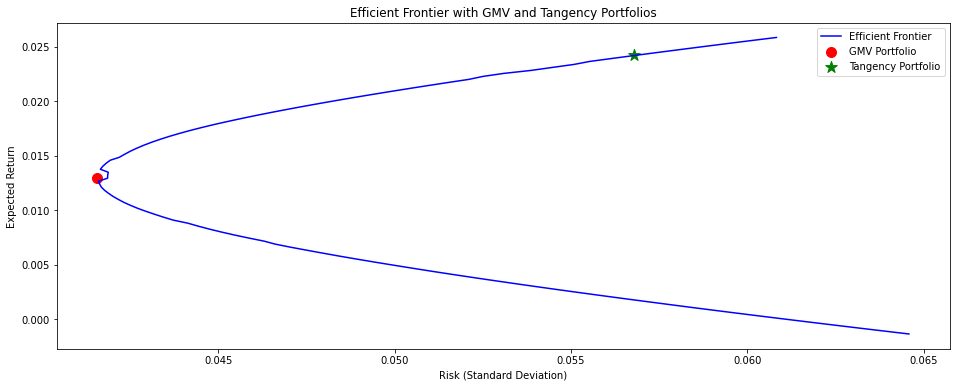

In [12]:
# Calculate efficient frontier, GMV, and Tangency portfolios
risks, returns = efficient_frontier(estimation_sample)
gmv_weights = compute_GMV(estimation_sample)
tangency_weights = compute_tangency_portfolio(estimation_sample, rf)

# Calculate GMV portfolio return and risk
gmv_return = gmv_weights.T @ estimation_sample.mean()
gmv_risk = np.sqrt(gmv_weights.T @ estimation_sample.cov() @ gmv_weights)

# Calculate Tangency portfolio return and risk
tangency_return = tangency_weights.T @ estimation_sample.mean()
tangency_risk = np.sqrt(tangency_weights.T @ estimation_sample.cov() @ tangency_weights)

# Plot the Efficient Frontier with GMV and Tangency portfolios
plt.figure(figsize=(16, 6))
plt.plot(risks, returns, 'b-', label='Efficient Frontier')
plt.scatter(gmv_risk, gmv_return, color='red', marker='o', s=100, label='GMV Portfolio')
plt.scatter(tangency_risk, tangency_return, color='green', marker='*', s=150, label='Tangency Portfolio')
plt.xlabel('Risk (Standard Deviation)')
plt.ylabel('Expected Return')
plt.title('Efficient Frontier with GMV and Tangency Portfolios')
plt.legend()
plt.show()


<a id='1.5'></a>
### 1.5  Rolling window analysis

In [13]:
rolling_window = 60

#### 1.5.1  Weights

functions to compute the weights at every point in time.

In [14]:
def compute_MVP(rets):
    covmatinv=np.linalg.inv(rets.cov())
    mu=rets.mean()
    w_mvp= covmatinv@(mu-rf)/(covmatinv@(mu-rf)@ones)
    return(w_mvp)

def compute_GMV(rets):
    covmatinv=np.linalg.inv(rets.cov())
    w_gmv = (covmatinv @ ones)/(ones.T@covmatinv @ ones)
    return(w_gmv)

In [16]:
# We loop over the dataset using each times the 60 last months to compute the new weights for the coming month
MVP_df=pd.DataFrame(columns=df_new.columns, index=df_new.index)
GMV_df=pd.DataFrame(columns=df_new.columns, index=df_new.index)
for i in range(rolling_window,len(df_new)):
    MVP_df.iloc[i,:]=compute_MVP(df_new.iloc[i-rolling_window:i,:]).reshape(10,)
    GMV_df.iloc[i,:]=compute_GMV(df_new.iloc[i-rolling_window:i,:]).reshape(10,)
    
MVP_df = MVP_df.dropna()
GMV_df = GMV_df.dropna()

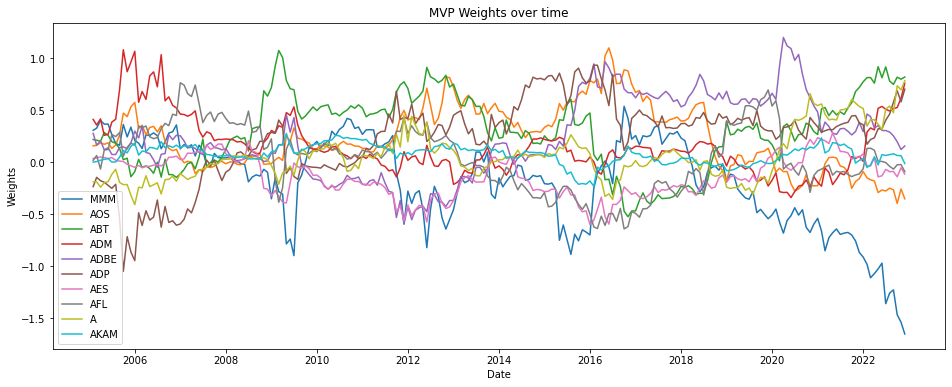

In [17]:
#Plotting weights of MVP portfolio:
plt.figure(figsize=(16,6))
plt.plot(MVP_df)
plt.legend(MVP_df.columns, loc='lower left')
plt.title('MVP Weights over time')
plt.ylabel('Weights')
plt.xlabel('Date')
plt.show()

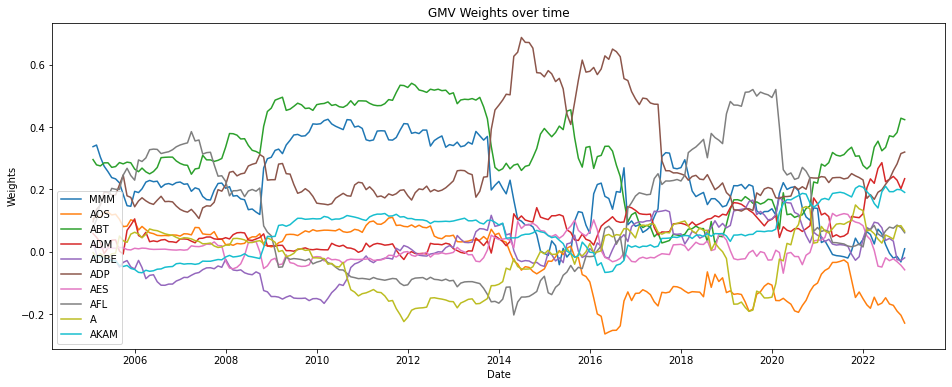

In [18]:
#Plotting weights of GMV portfolio:
plt.figure(figsize=(16,6))
plt.plot(GMV_df)
plt.legend(MVP_df.columns, loc='lower left')
plt.title('GMV Weights over time')
plt.ylabel('Weights')
plt.xlabel('Date')
plt.show()

#### 1.5.2  Returns

In [19]:
assets_returns=df_new.loc[GMV_df.index]

# we compute the portfolio returns by multiplying the weights computed in t with the returns in t+1
GMV_returns=pd.DataFrame(GMV_df.iloc[:-1,:].values*assets_returns.iloc[1:,:].values,columns=GMV_df.columns,index=assets_returns.iloc[1:,:].index)
GMV_returns["PTF_return"]=GMV_returns.sum(axis=1)
GMV_returns['cum_rets_ptf']=(1+GMV_returns['PTF_return']).cumprod()-1

In [20]:
MVP_returns=pd.DataFrame(MVP_df.iloc[:-1,:].values*assets_returns.iloc[1:,:].values,columns=MVP_df.columns,index=assets_returns.iloc[1:,:].index)
MVP_returns["PTF_return"]=MVP_returns.sum(axis=1)
MVP_returns['cum_rets_ptf']=(1+MVP_returns['PTF_return']).cumprod()-1


In [21]:
# to compare, we decided to also compute the returns for the equal weighted portfolio
EW_returns=pd.DataFrame(0.1*assets_returns.iloc[1:,:].values,columns=MVP_df.columns,index=assets_returns.iloc[1:,:].index)
EW_returns["PTF_return"]=EW_returns.sum(axis=1)
EW_returns['cum_rets_ptf']=(1+EW_returns['PTF_return']).cumprod()-1

#### 1.5.3  Cumulative Returns and Sharpe Ratios:

In [22]:
def sharperatio(x):
    return ((x['cum_rets_ptf'][-1])**(12/len(x))-1)/(x['PTF_return'].std()*np.sqrt(12))

In [23]:
# Compute Sharpe Ratios
sharpe_ratios_unconstrained = {
    "MVP": sharperatio(MVP_returns),
    "GMV": sharperatio(GMV_returns),
    "EW": sharperatio(EW_returns)
}

# Convert to DataFrame for better visualization
sharpe_df = pd.DataFrame(sharpe_ratios_unconstrained.items(), columns=["Portfolio", "Sharpe Ratio"]).T

sharpe_df

,0,1,2
Portfolio,MVP,GMV,EW
Sharpe Ratio,0.44841,0.696666,0.793706


The sharpe ratio of the GMV is threfore higher even if the absolute return of the MVP portfolio is higher. We can also get this intuition graphically below, we observe that the GMV cumulative return curve is muh more stable than the MVP one and suffer less from drawdowns.
Both portfolios are largely underperforming the equally weighted portfolio.

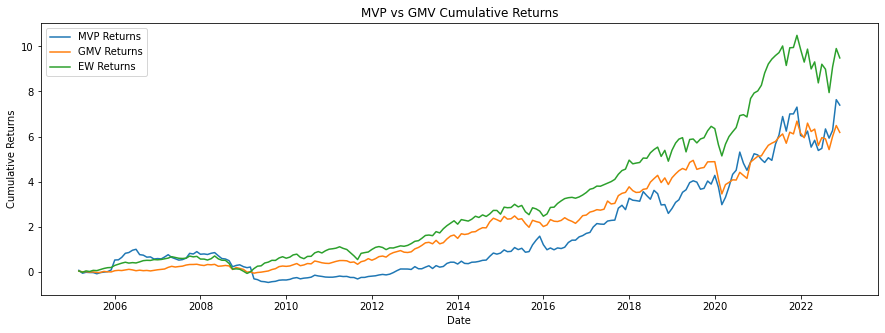

In [24]:
#Figure : 
plt.figure(figsize=(15,5))

# Plot cumulative returns:
plt.plot(MVP_returns['cum_rets_ptf'], label='MVP Returns')
plt.plot(GMV_returns['cum_rets_ptf'], label='GMV Returns')
plt.plot(EW_returns['cum_rets_ptf'], label='EW Returns')

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.title('MVP vs GMV Cumulative Returns')

# Add a legend
plt.legend()

# Show the plot
plt.show()


<a id='2'></a>
## <u> 2.MVP-Constrained & GMV-Constrained

There is now no closed form solution, we therefore have to use the optimizer:

<a id='2.1'></a>
### <u> 2.1 First window weights :

In [25]:
def objective(weights):
    portfolio_return = weights.T @ (mu_ER - rf)
    portfolio_risk = weights.T @ cov_mat @ weights
    return portfolio_risk-portfolio_return

# Define the initial guess for weights
initial_weights = np.ones(len(mu_ER))/len(mu_ER)

# Add a lower-bound constraint of 0 to the above problem

bounds = tuple((0, 1) for _ in range(len(mu_ER)))

# When calling minimize, we add ‘‘bounds’’ to the minimization function
result = minimize(objective, initial_weights, method="SLSQP", bounds = bounds)

# Extract the optimal weights from results
optimal_weights = result.x

#Weights of the ‘tangency’ portfolio
w_tangency = optimal_weights / (ones.T @ optimal_weights)

df_weight_mvpc = pd.DataFrame(w_tangency.reshape(1,10),columns = ["MMM","AOS","ABT","ADM","ADBE","ADP","AES","AFL","A","AKAM"])
df_weight_mvpc



,MMM,AOS,ABT,ADM,ADBE,ADP,AES,AFL,A,AKAM
0,0.230637,0.098666,0.203515,0.248778,0.115502,0.0,0.000334,0.102567,0.0,0.0


In [26]:
def objective(weights):
    portfolio_variance = weights.T @ cov_mat @ weights
    return portfolio_variance

# Define the equality constraint (weights sum to 1)
constraints = ({"type": "eq", "fun": lambda weights: np.sum(weights) -1})
# Define the initial guess for weights
initial_weights = np.ones(len(cov_mat)) / len(cov_mat)
# We now add to the code the short-sale constraint

bounds = tuple((0, 1) for _ in range(len(cov_mat)))

# Use scipy.optimize.minimize to find the optimal weights
result = minimize(objective, initial_weights, method="SLSQP", bounds=bounds, constraints=constraints)
# Extract the optimal weights
optimal_weights = result.x
# Print the results
print("\n* Using numeric solution with short-sale constraints")

df_weight_gmvc = pd.DataFrame(optimal_weights.reshape(1,10),columns = ["MMM","AOS","ABT","ADM","ADBE","ADP","AES","AFL","A","AKAM"])
df_weight_gmvc


* Using numeric solution with short-sale constraints


,MMM,AOS,ABT,ADM,ADBE,ADP,AES,AFL,A,AKAM
0,0.295284,0.088247,0.300789,0.068465,0.033232,0.082124,0.007249,0.124609,0.0,0.0


<a id='2.2'></a>
### <u> 2.2 Rolling Window Analysis :

#### <u> 2.2.1 Weights :

In [27]:
def compute_GMV_noshort(rets):

    covmat=rets.cov()
    #mu=rets.mean()
    
    def objective(weights, V):
        portfolio_variance = weights.T @ V @ weights
        return portfolio_variance

    # Define the equality constraint (weights sum to 1)
    constraints = ({"type": "eq", "fun": lambda weights: np.sum(weights) -
    1})

    # Define the initial guess for weights
    initial_weights = np.ones(len(covmat)) / len(covmat)

    # We now add to the code the short-sale constraint
    # Define the bounds for each weight (0 <= weight <= 999)
    bounds = tuple((0, 1) for _ in range(len(cov_mat_inv)))

    # Use scipy.optimize.minimize to find the optimal weights
    result = minimize(objective, initial_weights, args=(covmat,), method="SLSQP",
          bounds=bounds, constraints=constraints)
    # Extract the optimal weights
    optimal_weights = result.x
    return optimal_weights



def compute_MVP_noshort(rets):
    covmat=rets.cov()
    mu=rets.mean()
    def objective(weights):
        portfolio_return = weights.T @ (mu - rf )
        portfolio_risk = weights.T @ covmat @ weights
        return  portfolio_risk - portfolio_return

    # Define the initial guess for weights
    initial_weights = np.ones(len(mu))/len(mu)
    # Add a lower-bound constraint of 0 to the above problem
    # There is no upper bound, so I have set it to 999
    bounds = tuple((0, 1) for _ in range(len(mu)))
    # When calling minimize, we add ‘‘bounds’’ to the minimization function
    result = minimize(objective, initial_weights, method="SLSQP", bounds =
    bounds)

    # Extract the optimal weights from results
    optimal_weights = result.x/sum(result.x)
    #Weights in the risk-free asset
    w_riskFree = 1 - ones.T @ optimal_weights
    #Weights of the ‘‘tangency’’ portfolio
    w_tangency = optimal_weights / (ones.T @ optimal_weights)
    w_mvp_shortsaleConstrained = list(map(lambda num: format(num, ".6f"),
         optimal_weights))
    w_tangency_formatted = list(map(lambda num: format(num, ".6f"),
    w_tangency))
    return w_tangency
    
    

In [28]:
MVPC_df_noshort=pd.DataFrame(columns=df_new.columns, index=df_new.index)
GMVC_df_noshort=pd.DataFrame(columns=df_new.columns, index=df_new.index)


for i in range(rolling_window,len(df_new)):
    MVPC_df_noshort.iloc[i,:]=compute_MVP_noshort(df_new.iloc[i-rolling_window:i,:])
    GMVC_df_noshort.iloc[i,:]=compute_GMV_noshort(df_new.iloc[i-rolling_window:i,:])
    
    
MVPC_df_noshort=MVPC_df_noshort.dropna()
GMVC_df_noshort=GMVC_df_noshort.dropna()

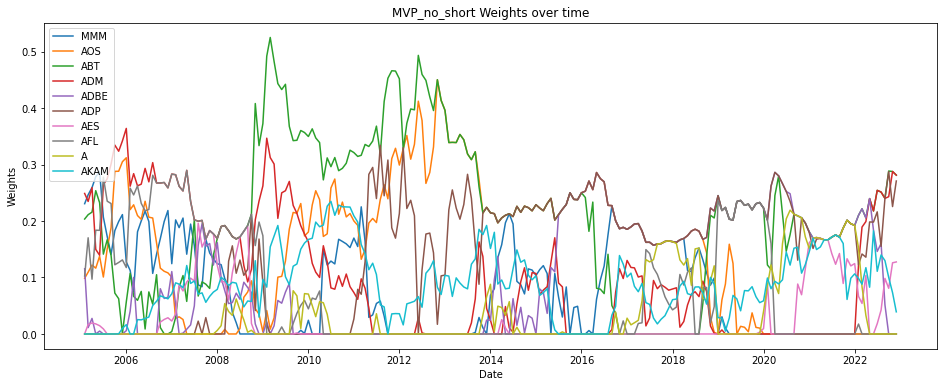

In [37]:
#Plotting weights of MVP_long_only portfolio:
plt.figure(figsize=(16,6))
plt.plot(MVPC_df_noshort)
plt.legend(MVPC_df_noshort.columns, loc='upper left')
plt.title('MVP_no_short Weights over time')
plt.ylabel('Weights')
plt.xlabel('Date')
plt.show()

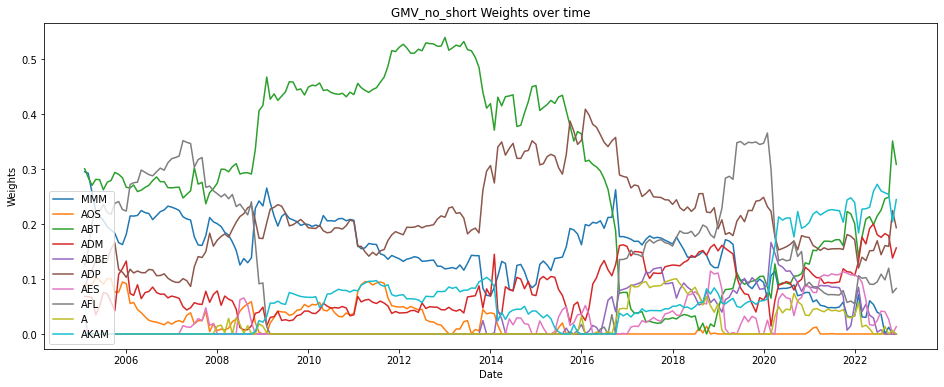

In [30]:
#Plotting weights of MVP_long_only portfolio:
plt.figure(figsize=(16,6))
plt.plot(GMVC_df_noshort)
plt.legend(GMVC_df_noshort.columns, loc='lower left')
plt.title('GMV_no_short Weights over time')
plt.ylabel('Weights')
plt.xlabel('Date')
plt.show()

#### <u> 2.2.2 Returns :

In [31]:
GMVC_df_noshort

Ticker,MMM,AOS,ABT,ADM,ADBE,ADP,AES,AFL,A,AKAM
Date,,,,,,,,,,
2005-02-01 00:00:00+00:00,0.295284,0.088247,0.300789,0.068465,0.033232,0.082124,0.007249,0.124609,0.0,0.0
2005-03-01 00:00:00+00:00,0.292929,0.089308,0.285356,0.068041,0.0,0.105252,0.006817,0.152297,0.0,0.0
2005-04-01 00:00:00+00:00,0.257709,0.087668,0.270573,0.066512,0.0,0.116162,0.000345,0.201032,0.0,0.0
2005-05-01 00:00:00+00:00,0.223231,0.102985,0.281431,0.034843,0.0,0.133099,0.0,0.224411,0.0,0.0
2005-06-01 00:00:00+00:00,0.214373,0.097946,0.280996,0.050341,0.0,0.13273,0.0,0.223613,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
2022-08-01 00:00:00+00:00,0.035593,0.0,0.22547,0.175983,0.007706,0.144254,0.041719,0.108865,0.0,0.26041
2022-09-01 00:00:00+00:00,0.0,0.0,0.24639,0.182722,0.0,0.16092,0.040531,0.098485,0.013776,0.257175
2022-10-01 00:00:00+00:00,0.012321,0.0,0.249054,0.17869,0.0,0.159498,0.026769,0.119764,0.0,0.253905


In [33]:
GMVCnoshort_returns=pd.DataFrame(GMVC_df_noshort.iloc[:-1,:].values*assets_returns.iloc[1:,:].values,columns=GMVC_df_noshort.columns,index=assets_returns.iloc[1:,:].index)
GMVCnoshort_returns["PTF_return"]=GMVCnoshort_returns.sum(axis=1)
GMVCnoshort_returns['cum_rets_ptf']=(1+GMVCnoshort_returns['PTF_return']).cumprod()-1

In [34]:
MVPCnoshort_returns=pd.DataFrame(MVPC_df_noshort.iloc[:-1,:].values*assets_returns.iloc[1:,:].values,columns=MVPC_df_noshort.columns,index=assets_returns.iloc[1:,:].index)
MVPCnoshort_returns["PTF_return"]=MVPCnoshort_returns.sum(axis=1)
MVPCnoshort_returns['cum_rets_ptf']=(1+MVPCnoshort_returns['PTF_return']).cumprod()-1

#### <u> 2.2.3 Comparison :

Sharpe ratios:

In [35]:
# Compute Sharpe Ratios
sharpe_ratios = {
    "MVP-C": sharperatio(MVPCnoshort_returns),
    "GMV-C": sharperatio(GMVCnoshort_returns),
    "MVP": sharperatio(MVP_returns),
    "GMV": sharperatio(GMV_returns),
    "EW": sharperatio(EW_returns)
}

# Convert to DataFrame for better visualization
sharpe_df = pd.DataFrame(sharpe_ratios.items(), columns=["Portfolio", "Sharpe Ratio"]).T

sharpe_df

,0,1,2,3,4
Portfolio,MVP-C,GMV-C,MVP,GMV,EW
Sharpe Ratio,0.650515,0.742926,0.44841,0.696666,0.793706


Both of the constrained strategies outperform significativel their respective non-constrained version !

The GMVC strategy has the overall best Sharpe ratio !

However, even the GMV-C is still underperforming the equally weighted portfolio... 

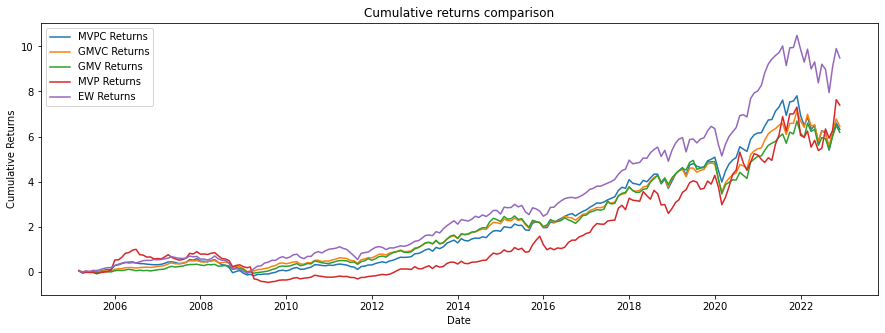

In [36]:
#Figure: 
plt.figure(figsize=(15,5))

# Plot cumulative returns
plt.plot(MVPCnoshort_returns['cum_rets_ptf'], label='MVPC Returns')
plt.plot(GMVCnoshort_returns['cum_rets_ptf'], label='GMVC Returns')
plt.plot(GMV_returns['cum_rets_ptf'], label='GMV Returns')
plt.plot(MVP_returns['cum_rets_ptf'], label='MVP Returns')
plt.plot(EW_returns['cum_rets_ptf'], label='EW Returns')


# Add labels and title
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.title('Cumulative returns comparison')

# Add a legend
plt.legend()

# Show the plot
plt.show()

<a id='3'></a>
## <u> 3. Conclusion

Among the four strategies, the GMV-C (Constrained Global Minimum Variance) portfolio has the highest Sharpe ratio, followed by the GMV (Global Minimum Variance), then the MVP-C (Constrained Minimum Variance Portfolio), with the unconstrained MVP (Minimum Variance Portfolio) having the lowest Sharpe ratio.

According to Markowitz’s theory, we would expect the reverse order: the optimal MVP, or tangent portfolio, should ideally deliver the highest Sharpe ratio, while the addition of constraints typically moves us away from this optimal point.

The reason behind this deviation lies in estimation errors, particularly in the expected returns and covariance matrix estimations. Expected returns, in particular, tend to have significant estimation errors, which impacts the performance of portfolios relying heavily on these estimates. As a result, GMV portfolios—requiring only covariance estimates—often outperform MVP portfolios, which also depend on less reliable expected return estimates.

Adding constraints helps to mitigate these estimation errors by effectively shrinking extreme values, bringing the portfolios closer to an "optimal" point despite the inherent estimation challenges.